# Modeling distributions

The distributions we have used so far are called **empirical distributions** because they are based on empirical observations -- in other words, data.

Many datasets we see in the real world can be closely approximated by a **theoretical distribution**, which is usually based on a simple mathematical model.

This chapter presents some of these theoretical distribution and examples of datasets they can be used to model.

As examples, we'll see that:

* In a skeet shooting competition, the number of hits and misses is well modeled by a binomial distribution.

* In games like hockey and soccer (football), the number of goals in a game follows a Poisson distribution, and the time between goals follows an exponential distribution.

* Birth weights follow a normal distribution, also called a Gaussian distribution.

* Adult weights follow a lognormal distribution.

If you are not familiar with these distributions -- or these sports -- I will explain what you need to know.

For each example, we'll start with a simulation based on a simple model of a real-world scenario, and show that the simulation results follow an analytic distribution.
Then we'll see how well real data agrees with the model.



In [2]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

<IPython.core.display.Javascript object>

## The Binomial Distribution

As a first example, let's consider the sport of skeet shooting, in which competitors use shotguns to shoot clay disks that are thrown into the air.
In international competition, including the Olympics, there are five rounds with 25 targets per round, with additional rounds as needed to determine a winner.

As a model of a skeet-shooting competition, let suppose that every participant has the same probability of hitting every target, `p`.
Of course, this model is a simplification -- in reality, it's likely that some competitors have a higher probability than others, and even for a single competitor, it might vary from one attempt to the next.
But even if it is not realistic, this model make some remarkable predictions, as we'll see.

To simulate the model, I'll use the following function, which takes the number of targets, `n`, and the probability of hitting each one, `p`, and returns a sequence of 1s and 0s to indicate hits and misses.

In [5]:
def flip(n, p):
    choices = [1, 0]
    probs = [p, 1 - p]
    return np.random.choice(choices, n, p=probs)

<IPython.core.display.Javascript object>

Here's an example that simulates a round of 25 targets where the probability of hitting each one is 90%.

In [6]:
flip(25, 0.9)

array([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

<IPython.core.display.Javascript object>

If we generate a sequence of 1000 attempts, and compute the `Pmf` of the results, we can check whether the proportions of 1s and 0s are correct. 

In [7]:
from empiricaldist import Pmf

seq = flip(1000, 0.9)
pmf = Pmf.from_seq(seq)
pmf

,probs
0,0.093
1,0.907


<IPython.core.display.Javascript object>

And they are, at least approximately.
Now we can use `flip` to simulate a round of skeet shooting and return the number of hits.

In [8]:
def simulate_round(n, p):
    seq = flip(n, p)
    return seq.sum()

<IPython.core.display.Javascript object>

In a large competition, suppose 200 competitors shoot 5 rounds each, all with the same probability of hitting the target, `p=0.9`.
We can simulate a competition like that by calling `simulate_round` 1000 times.

In [9]:
n = 25
p = 0.9
results_sim = [simulate_round(n, p) for i in range(1000)]

<IPython.core.display.Javascript object>

The average score is close to `22.5`, which is the product of `n` and `p`.

In [10]:
np.mean(results_sim), n * p

(22.531, 22.5)

<IPython.core.display.Javascript object>

Here's what the distribution of the results looks like.

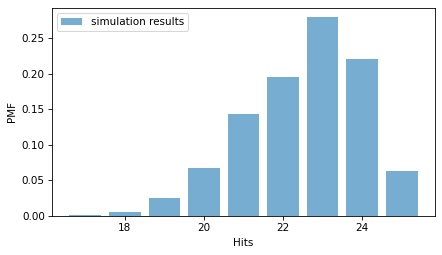

<IPython.core.display.Javascript object>

In [11]:
from empiricaldist import Pmf

pmf_sim = Pmf.from_seq(results_sim, name="simulation results")

pmf_sim.bar(alpha=0.6)
decorate(xlabel="Hits", ylabel="PMF")

Instead of running a simulation, we could have predicted this distribution.
Mathematically, we can show that the distribution of these outcomes follows a binomial distribution, which has a PMF that is easy to compute.

In [12]:
from scipy.special import comb


def binomial_pmf(k, n, p):
    """Compute the binomial PMF.

    k (int or array-like): number of successes
    n (int): number of trials
    p (float): probability of success on a single trial

    returns: float or ndarray
    """
    return comb(n, k) * (p**k) * ((1 - p) ** (n - k))

<IPython.core.display.Javascript object>

This function computes the probability of getting `k` hits out of `n` attempts, given `p`.
If we call this function with a range of `k`, we can make a `Pmf` that represents the distribution of the outcomes.

In [13]:
ks = np.arange(16, n + 1)
ps = binomial_pmf(ks, n, p)
pmf_binom = Pmf(ps, ks, name="binomial model")

<IPython.core.display.Javascript object>

And here's what it looks like compared to the simulation results.

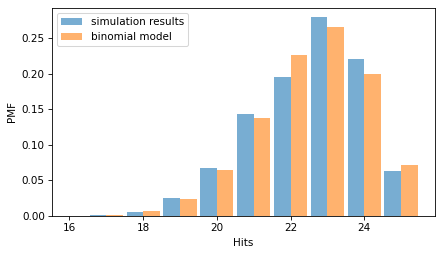

<IPython.core.display.Javascript object>

In [14]:
from thinkstats import two_bar_plots

two_bar_plots(pmf_sim, pmf_binom)
decorate(xlabel="Hits", ylabel="PMF")

They are similar, with small differences because of random variation in the simulation results.

This agreement should not be surprising, because the simulation and the model are based on the same assumptions -- particularly the assumption that every attempt has the same probability of success.
The real test of a model is how it compares to real data.

From the Wikipedia page for the men's skeet shooting competition at the 2020 Summer Olympics, we can extract a table that shows the results for the qualification rounds of the competition.

Downloaded from <https://en.wikipedia.org/wiki/Shooting_at_the_2020_Summer_Olympics_–_Men's_skeet> on July 15, 2024.

In [15]:
filename = "Shooting_at_the_2020_Summer_Olympics_–_Men's_skeet"
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/" + filename)

<IPython.core.display.Javascript object>

In [91]:
tables = pd.read_html("Shooting_at_the_2020_Summer_Olympics_–_Men's_skeet")
table = tables[6]
table.head()

,Rank,Athlete,Country,1,2,3,4,5,Total[3],Shoot-off,Notes
0,1,Éric Delaunay,France,25,25,25,24,25,124,+6,"Q, OR"
1,2,Tammaro Cassandro,Italy,24,25,25,25,25,124,+5,"Q, OR"
2,3,Eetu Kallioinen,Finland,25,25,24,25,24,123,NaN,Q
3,4,Vincent Hancock,United States,25,25,25,25,22,122,+8,Q
4,5,Abdullah Al-Rashidi,Kuwait,25,25,24,25,23,122,+7,Q


<IPython.core.display.Javascript object>

The table has one row for each competitor, with one column for each of five rounds.
We'll select the columns that contain the results and use `flatten` to put them into a single array.

In [ ]:
columns = ["1", "2", "3", "4", "5"]
results = table[columns].values.flatten()

In [93]:
total_shots = 25 * len(results)
total_hits = results.sum()
n, total_shots, total_hits

(150, 3750, 3575)

<IPython.core.display.Javascript object>

With 30 competitors, we have results from 150 rounds of 25 shots each, with 3750 hits out of a total of 3575 attempts.

In [19]:
p = total_hits / total_shots
p

0.9533333333333334

<IPython.core.display.Javascript object>

So the overall success rate is 95.3%.
Now we can compute a `Pmf` that represents the binomial distribution with `n=25` and the value of `p` we just computed.

In [20]:
n = 25
ks = np.arange(16, n + 1)
ps = binomial_pmf(ks, n, p)
pmf_binom = Pmf(ps, ks, name="binomial model")

<IPython.core.display.Javascript object>

And we can compare that to the `Pmf` of the actual results.

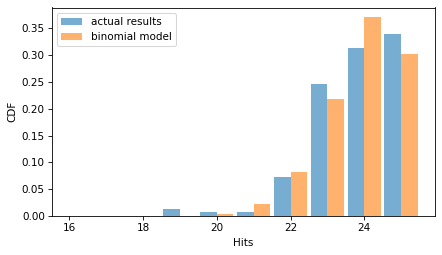

<IPython.core.display.Javascript object>

In [22]:
pmf_results = Pmf.from_seq(results, name="actual results")

two_bar_plots(pmf_results, pmf_binom)
decorate(xlabel="Hits", ylabel="CDF")

The binomial model is a good fit for the distribution of the data.

## The Poisson Distribution

As another example where the outcomes of sports events follow predictable patterns, let's look at the number of goals scored in ice hockey games.

We'll start by simulating a game of ice hockey that lasts 60 minutes, which is 3600 seconds. We'll assume that the teams score a total of 6 goals per game, on average, and that the probability of scoring a goal during any second is the same.

In [136]:
n = 3600
m = 6
p = m / 3600
p

0.0016666666666666668

<IPython.core.display.Javascript object>

Now we can use the following function to simulate `n` second and return the total number of goals scored.

In [137]:
def simulate_goals(n, p):
    return flip(n, p).sum()

<IPython.core.display.Javascript object>

If we simulate 1000 games, we can confirm that the average number of goals per game is close to 6.

In [138]:
goals = [simulate_goals(n, p) for i in range(1001)]
np.mean(goals)

6.036963036963037

<IPython.core.display.Javascript object>

And we can compute the `Pmf` of the number of goals.

We could use the binomial distribution to model these results, but when `n` is large and `p` is small, the results are also well-modeled by a Poisson distribution, which has just one parameter, denoted with the Greek letter λ, which is pronounced "lambda" and represented in code with the variable `lam` (because `lambda` is a Python keyword).
`lam` represents the rate of goal-scoring, which is 6 goals per game.

The PMF of the Poisson distribution is easy to compute -- given `lam`, we can use the following function to compute the probability of seeing `k` goals in a game.

In [139]:
from scipy.special import factorial


def poisson_pmf(k, lam):
    """Compute the Poisson PMF.

    k (int or array-like): The number of occurrences
    lam (float): The rate parameter (λ) of the Poisson distribution

    returns: float or ndarray
    """
    return (lam**k) * np.exp(-lam) / factorial(k)

<IPython.core.display.Javascript object>

If we call this function with a range of `k` values, we can compute the distribution of outcomes.

In [140]:
lam = 6
ks = np.arange(20)
ps = poisson_pmf(ks, lam)
pmf_poisson = Pmf(ps, ks, name="Poisson model")
pmf_poisson.sum()

0.999994819831063

<IPython.core.display.Javascript object>

And confirm that the mean of the distribution is close to 6.

In [141]:
pmf_poisson.normalize()
pmf_poisson.mean()

5.999925498375129

<IPython.core.display.Javascript object>

The following figure compares the results from the simulation to the Poisson distribution with the same mean.

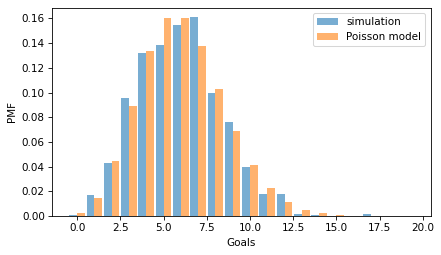

<IPython.core.display.Javascript object>

In [142]:
pmf_sim = Pmf.from_seq(goals, name="simulation")

two_bar_plots(pmf_sim, pmf_poisson)
decorate(xlabel="Goals", ylabel="PMF")

The distributions are similar except for small differences due to random variation.
That should not be surprising, because the simulation and the Poisson model are based on the same assumption, notably that the probability of scoring a goal is the same during any second of the game.
So the real test is to see how well the model fits real data.

From HockeyReference, I downloaded results of every game of the National Hockey League (NHL) 2023-2024 regular season (not including the playoffs).
I extracted information about goals scored during 60 minutes of regulation play, not including overtime or tie-breaking shootouts.
The results are in an HDF file with one key for each game, and a list of times, in seconds since the beginning of the game, when a goal was scored.

Downloaded from <https://www.hockey-reference.com/leagues/NHL_2024_games.html> on July 16, 2024.

In [117]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/nhl_2023_2024.hdf")

<IPython.core.display.Javascript object>

Here's how we read the keys from the file.

In [123]:
filename = "nhl_2023_2024.hdf"

with pd.HDFStore(filename, "r") as store:
    keys = store.keys()

len(keys), keys[0]

(1312, '/202310100PIT')

<IPython.core.display.Javascript object>

There were 1312 games during the regular season.
Each key represents the date of the game and a three-letter abbreviation for the home team.
We can use `read_hdf` to look up a key and get the list of times when a goal was scored.


In [126]:
times = pd.read_hdf(filename, key=keys[0])
times

0     424
1    1916
2    2137
3    3005
4    3329
5    3513
dtype: int64

<IPython.core.display.Javascript object>

In the first game of the season, six goals were scored, the first after 424 second of play, the last at after 3513 seconds, with only 87 second left in the game.

In [128]:
3600 - times[5]

87

<IPython.core.display.Javascript object>

The following loop reads the results for all games, counts the number of goals, and stores the result in a list.

In [170]:
goals = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    n = len(times)
    goals.append(n)

<IPython.core.display.Javascript object>

The average number of goals per game is just over 6.

In [171]:
lam = np.mean(goals)
lam

6.0182926829268295

<IPython.core.display.Javascript object>

We can use `poisson_pmf` to make a `Pmf` that represents a Poisson distribution with the same mean as the data.

In [172]:
ks = np.arange(25)
ps = poisson_pmf(ks, lam)
pmf_poisson = Pmf(ps, ks, name="Poisson model")

<IPython.core.display.Javascript object>

In [173]:
pmf_poisson.sum()

0.9999999937565296

<IPython.core.display.Javascript object>

And here's what it looks like compared to the PMF of the data.

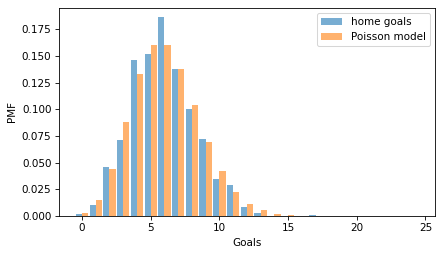

<IPython.core.display.Javascript object>

In [174]:
pmf_goals = Pmf.from_seq(goals, name="home goals")

two_bar_plots(pmf_goals, pmf_poisson)
decorate(xlabel="Goals", ylabel="PMF")

The data fit the Poisson model remarkably well.

## The Exponential Distribution

In the previous section, we simulated a simple model of a hockey game where a goal has the same probability of being scored during any second of the game.
Under the same model, it turns out, the time until the first goal follows an **exponential distribution**.

As an example, let's assume again that the average number of goals per game is 6 and compute the probabilyt of a goal during any particular second.

In [160]:
n = 3600
m = 6
p = m / 3600
p

0.0016666666666666668

<IPython.core.display.Javascript object>

The following function simulates `n` seconds and uses `argmax` to find and return the time of the first goal.

In [161]:
def simulate_first_goal(n, p):
    return flip(n, p).argmax()

<IPython.core.display.Javascript object>

This works because the result from `flip` is a sequence of 1s and 0s, so the maximum is almost always 1.
If there is at least one goal in the sequence, `argmax` returns the index of the first 1.
If there are no goals, it returns 0, but that happens seldom enough that we'll ignore it.

We'll use `simulate_first_goal` to simulate 1001 games and make a list of the times until the first goal.

In [162]:
first_goal_times = [simulate_first_goal(n, p) for i in range(1001)]
mean = np.mean(first_goal_times)
mean

580.3206793206793

<IPython.core.display.Javascript object>

The average time until the first goal is about 600 seconds, or 10 minutes.
And that makes sense -- if we expect 6 goals per game, we expect one goal every 10 minutes, on average.

When `n` is large and `p` is small, we can show mathematically that the expected time until the first goal follows an exponential distribution.
And the CDF of the exponential distribution is easy to compute.

In [163]:
def exponential_cdf(t, lam):
    return 1 - np.exp(-lam * t)

<IPython.core.display.Javascript object>

The parameter, `lam`, is the average number of events per unit of time -- in this example it is goals per second.
We can use the mean of the simulated results to compute lam.

In [164]:
lam = 1 / mean
lam

0.001723185189903271

<IPython.core.display.Javascript object>

If we call this function with a range of time values, `ts`, we can approximate the distribution of first goal times.

In [165]:
ts = np.linspace(0, 3600, 201)
ps = exponential_cdf(ts, lam)
cdf_expo = Cdf(ps, ts, name="exponential model")

<IPython.core.display.Javascript object>

The following figure compares the simulation results to the exponential distribution we just computed.
Because there are many unique time values, we'll use CDFs to compare the distributions, rather than PMFs.

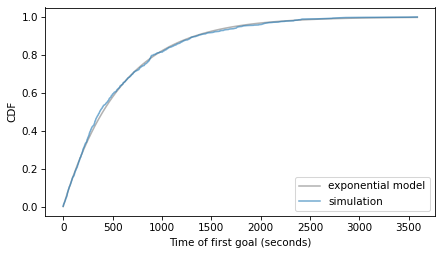

<IPython.core.display.Javascript object>

In [169]:
cdf_sim = Cdf.from_seq(first_goal_times, name="simulation")

cdf_expo.plot(alpha=0.6, color="gray")
cdf_sim.plot(alpha=0.6)

decorate(xlabel="Time of first goal (seconds)", ylabel="CDF")

The exponential model fits the results from the simulation very well.
But the real test is to see whether it does as well with real data.

The following loop reads the results for all games, gets the time of the first goal, and stores the result in a list.
If no goals were scored, it adds `nan` to the list.

In [175]:
filename = "nhl_2023_2024.hdf"

with pd.HDFStore(filename, "r") as store:
    keys = store.keys()

<IPython.core.display.Javascript object>

In [176]:
firsts = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    if len(times) > 0:
        firsts.append(times[0])
    else:
        firsts.append(np.nan)

<IPython.core.display.Javascript object>

To compute the goal-scoring rate, we can use `nanmean`, which computes the mean of the times, ignoring `nan` values.

In [178]:
lam = 1 / np.nanmean(firsts)
lam

0.0015121567467720825

<IPython.core.display.Javascript object>

Now we can compute the CDF of an exponential distribution with the same goal-scoring rate as the data.

In [184]:
ts = np.linspace(0, 3600, 201)
ps = exponential_cdf(ts, lam)
cdf_expo = Cdf(ps, ts, name="exponential model")

<IPython.core.display.Javascript object>

To compute the CDF of the data, we use the `dropna=False` argument, which includes `nan` values at the end.

In [185]:
cdf_firsts = Cdf.from_seq(firsts, name="data", dropna=False)
cdf_firsts.tail()

,probs
3286.0,0.996951
3581.0,0.997713
NaN,1.000000


<IPython.core.display.Javascript object>

The following figure compares the exponential distribution to the distribution of the data.

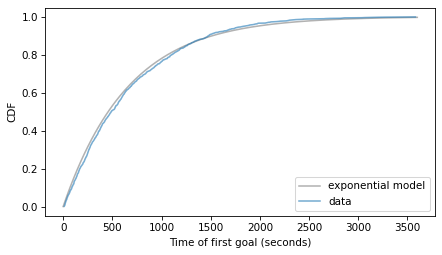

<IPython.core.display.Javascript object>

In [186]:
cdf_expo.plot(alpha=0.6, color="gray")
cdf_firsts.plot(alpha=0.6)

decorate(xlabel="Time of first goal (seconds)", ylabel="CDF")

The data deviate from the model in some places -- it looks like there are fewer goals in the first 1000 seconds than the model predicts.
But still, the model fits the data well.

If you ask a hockey fan whether a goal is equally likely during any second of a game, which is the underlying assumption of the Poisson model of goals and the exponential model of times, they would say no.
And they would be right -- the real world violates assumptions like these in many ways.
Despite these violations, theoretical distributions often fit real data remarkably well.

## The Normal Distribution

Suppose you grow pumpkins

In [226]:
def simulate_growth(n):
    choices = [1, 2, 3]
    gains = np.random.choice(choices, n)
    return gains.sum()

<IPython.core.display.Javascript object>

In [227]:
weights = [simulate_growth(100) for i in range(1001)]
m, s = np.mean(weights), np.std(weights)
m, s

(200.1008991008991, 8.277336219818142)

<IPython.core.display.Javascript object>

In [233]:
from scipy.stats import norm

low, high = np.min(weights), np.max(weights)
qs = np.linspace(low, high, 201)
ps = norm.cdf(qs, m, s)
cdf_sim = Cdf(ps, qs, name="normal model")

<IPython.core.display.Javascript object>

In [234]:
cdf_weights = Cdf.from_seq(weights, name="simulation")

<IPython.core.display.Javascript object>

In [241]:
# TODO: Make simulation curves orange

<IPython.core.display.Javascript object>

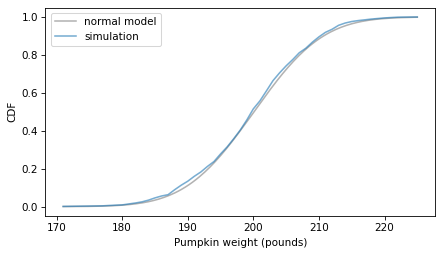

<IPython.core.display.Javascript object>

In [235]:
cdf_sim.plot(color="gray", alpha=0.6)
cdf_weights.plot(alpha=0.6)

decorate(xlabel="Pumpkin weight (pounds)", ylabel="CDF")

In the previous chapter we looked at the distribution of birth weights in the NSFG.
The following figure shows the empirical CDF of weights for all live births and the CDF of a normal distribution with the same mean and variance.

In [190]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

<IPython.core.display.Javascript object>

In [236]:
import nsfg

preg = nsfg.read_fem_preg()
birth_weights = preg["totalwgt_lb"].dropna()

<IPython.core.display.Javascript object>

In [237]:
from empiricaldist import Cdf

cdf_birth_weight = Cdf.from_seq(birth_weights, name="sample")

<IPython.core.display.Javascript object>

In [238]:
m, s = np.mean(birth_weights), np.std(birth_weights)
m, s

(7.265628457623368, 1.40821553384062)

<IPython.core.display.Javascript object>

In [239]:
from scipy.stats import trimboth

trimmed = trimboth(birth_weights, 0.01)
m, s = np.mean(trimmed), np.std(trimmed)
m, s

(7.280883100022579, 1.2430657948614345)

<IPython.core.display.Javascript object>

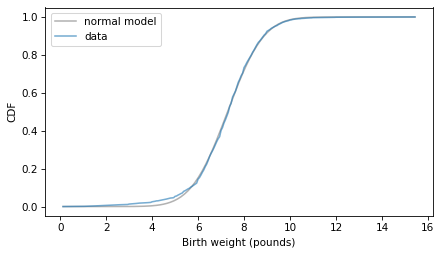

<IPython.core.display.Javascript object>

In [240]:
low, high = np.min(birth_weights), np.max(birth_weights)
xs = np.linspace(low, high, 201)

ps = norm.cdf(xs, m, s)
plt.plot(xs, ps, color="gray", alpha=0.6, label="normal model")

cdf_birth_weight.plot(alpha=0.6, label="data")

decorate(xlabel="Birth weight (pounds)", ylabel="CDF")

## The lognormal distribution

If the logarithms of a set of values have a normal distribution, the values have a **lognormal distribution**.
The CDF of the lognormal distribution is the same as the CDF of the normal distribution, with $\log x$ substituted for $x$.

$$CDF_{lognormal}(x) = CDF_{normal}(\log x)$$

The parameters of the lognormal distribution are usually denoted $\mu$ and $\sigma$.
But remember that these parameters are *not* the mean and standard deviation; the mean of a lognormal distribution is $\exp(\mu +\sigma^2/2)$ and the standard deviation is ugly (see <http://wikipedia.org/wiki/Log-normal_distribution>).

In [280]:
def simulate_proportionate_growth(n):
    choices = [1.03, 1.05, 1.07]
    gains = np.random.choice(choices, n)
    return gains.prod()

<IPython.core.display.Javascript object>

In [281]:
weights = [simulate_proportionate_growth(100) for i in range(1001)]
np.mean(weights), np.std(weights)

(131.60367202039063, 20.061394041006118)

<IPython.core.display.Javascript object>

In [282]:
log_weights = np.log10(weights)
m, s = np.mean(log_weights), np.std(log_weights)
m, s

(2.114283236187875, 0.06576844872638053)

<IPython.core.display.Javascript object>

I use log10 because it doesn't matter and it's interpretable

In [283]:
from scipy.stats import norm

low, high = np.min(log_weights), np.max(log_weights)
qs = np.linspace(low, high, 201)
ps = norm.cdf(qs, m, s)
cdf_normal = Cdf(ps, qs, name="normal model")

<IPython.core.display.Javascript object>

In [284]:
cdf_log_weights = Cdf.from_seq(log_weights, name="simulation")

<IPython.core.display.Javascript object>

In [285]:
# TODO: Make simulation curves orange

<IPython.core.display.Javascript object>

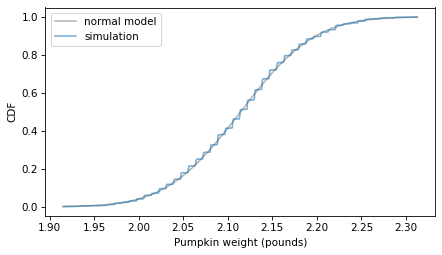

<IPython.core.display.Javascript object>

In [286]:
cdf_normal.plot(color="gray", alpha=0.6)
cdf_log_weights.plot(alpha=0.6)

decorate(xlabel="Pumpkin weight (pounds)", ylabel="CDF")



As an example, let's look at the distribution of adult weights

The National Center for Chronic Disease Prevention and Health Promotion conducts an annual survey as part of the Behavioral Risk Factor Surveillance System (BRFSS).[^3] In 2008, they interviewed 414,509 respondents and asked about their demographics, health, and health risks.
Among the data they collected are the weights in kilograms of 398,484 respondents.

The repository for this book contains `CDBRFS08.ASC.gz`, a fixed-width ASCII file that contains data from the BRFSS, and `brfss.py`, which reads the file and analyzes the data.

In [287]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/brfss.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/CDBRFS08.ASC.gz")

<IPython.core.display.Javascript object>

In [288]:
from thinkstats import read_brfss

brfss = read_brfss()

<IPython.core.display.Javascript object>

In [298]:
adult_weights = brfss["wtkg2"].dropna()
m, s = np.mean(adult_weights), np.std(adult_weights)
m, s

(78.9924529968581, 19.546132387397257)

<IPython.core.display.Javascript object>

In [299]:
low, high = np.min(adult_weights), np.max(adult_weights)
qs = np.linspace(low, high, 201)
ps = norm.cdf(qs, m, s)
cdf_normal = Cdf(ps, qs, name="normal model")

<IPython.core.display.Javascript object>

In [300]:
cdf_adult_weights = Cdf.from_seq(adult_weights, name="adult weight")

<IPython.core.display.Javascript object>

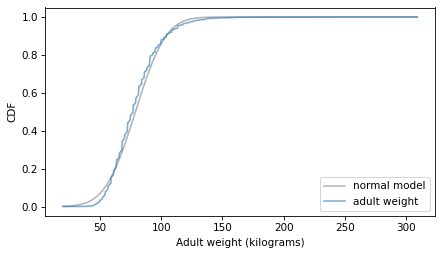

<IPython.core.display.Javascript object>

In [301]:
cdf_normal.plot(color="gray", alpha=0.6)
cdf_adult_weights.plot(alpha=0.6)

decorate(xlabel="Adult weight (kilograms)", ylabel="CDF")

In [306]:
log_adult_weights = np.log10(adult_weights)

<IPython.core.display.Javascript object>

In [307]:
def make_normal_model(seq):
    m, s = np.mean(seq), np.std(seq)
    low, high = np.min(seq), np.max(seq)
    qs = np.linspace(low, high, 201)
    ps = norm.cdf(qs, m, s)
    return Cdf(ps, qs, name="normal model")

<IPython.core.display.Javascript object>

In [308]:
cdf_normal = make_normal_model(log_adult_weights)

<IPython.core.display.Javascript object>

In [309]:
cdf_log_adult_weights = Cdf.from_seq(log_adult_weights, name="log adult weight")

<IPython.core.display.Javascript object>

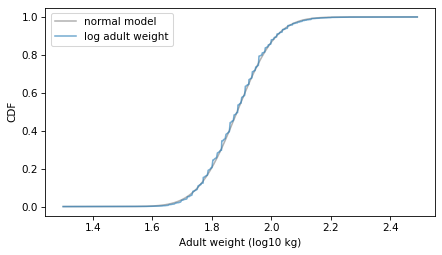

<IPython.core.display.Javascript object>

In [310]:
cdf_normal.plot(color="gray", alpha=0.6)
cdf_log_adult_weights.plot(alpha=0.6)

decorate(xlabel="Adult weight (log10 kg)", ylabel="CDF")

The following figure (left) shows the distribution of adult weights on a linear scale with a normal model.
The following figure (right) shows the same distribution on a log scale with a lognormal model.
The lognormal model is a better fit, but this representation of the data does not make the difference particularly dramatic.

The following figure shows normal probability plots for adult weights, $w$, and for their logarithms, $\log_{10} w$. Now it is apparent that the data deviate substantially from the normal model.
On the other hand, the lognormal model is a good match for the data.

## The Pareto distribution

The **Pareto distribution** is named after the economist Vilfredo Pareto, who used it to describe the distribution of wealth (see <http://wikipedia.org/wiki/Pareto_distribution>).
Since then, it has been used to describe phenomena in the natural and social sciences including sizes of cities and towns, sand particles and meteorites, forest fires and earthquakes.

The CDF of the Pareto distribution is:

$$CDF(x) = 1 - \left( \frac{x}{x_m} \right) ^{-\alpha}$$

The parameters $x_{m}$ and $\alpha$ determine the location and shape of the distribution.
$x_{m}$ is the minimum possible value.
The following figure shows CDFs of Pareto distributions with $x_{m} = 0.5$ and different values of $\alpha$.

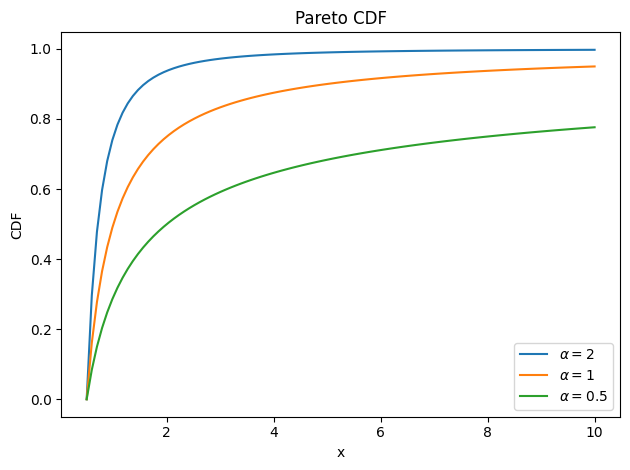

<IPython.core.display.Javascript object>

In [23]:
from thinkstats import render_pareto_cdf

xmin = 0.5
for alpha in [2.0, 1.0, 0.5]:
    xs, ps = render_pareto_cdf(xmin, alpha, 0, 10.0, n=100)
    plt.plot(xs, ps, label="$\\alpha=%g$" % alpha)

decorate(title="Pareto CDF", xlabel="x", ylabel="CDF", loc="lower right")

There is a simple visual test that indicates whether an empirical distribution fits a Pareto distribution: on a log-log scale, the CCDF looks like a straight line.
Let's see why that works.

If you plot the CCDF of a sample from a Pareto distribution on a linear scale, you expect to see a function like: $$y \approx \left( \frac{x}{x_m} \right) ^{-\alpha}$$ Taking the log of both sides yields: $$\log y \approx -\alpha (\log x - \log x_{m})$$ So if you plot $\log y$ versus $\log x$, it should look like a straight line with slope $-\alpha$ and intercept $\alpha \log x_{m}$.

As an example, let's look at the sizes of cities and towns.
The U.S. Census Bureau publishes the population of every incorporated city and town in the United States.

In [24]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/populations.py")
download(
    "https://github.com/AllenDowney/ThinkStats/raw/v3/data/PEP_2012_PEPANNRES_with_ann.csv"
)

<IPython.core.display.Javascript object>

In [25]:
import populations

pops = populations.read_data()
print("Number of cities/towns", len(pops))

Number of cities/towns 19515


<IPython.core.display.Javascript object>

I downloaded their data from <http://www.census.gov/popest/data/cities/totals/2012/SUB-EST2012-3.html>; it is in the repository for this book in a file named `PEP_2012_PEPANNRES_with_ann.csv`.
The repository also contains `populations.py`, which reads the file and plots the distribution of populations.

The following figure shows the CCDF of populations on a log-log scale.
The largest 1% of cities and towns, below $10^{-2}$, fall along a straight line.
So we could conclude, as some researchers have, that the tail of this distribution fits a Pareto model.

On the other hand, a lognormal distribution also models the data well.
The following figure shows the CDF of populations and a lognormal model (left), and a normal probability plot (right).
Both plots show good agreement between the data and the model.

Neither model is perfect.
The Pareto model only applies to the largest 1% of cities, but it is a better fit for that part of the distribution.
The lognormal model is a better fit for the other 99%.
Which model is appropriate depends on which part of the distribution is relevant.

In [26]:
log_pops = np.log10(pops)
cdf = Cdf.from_seq(pops, name="data")
cdf_log = Cdf.from_seq(log_pops, name="data")

<IPython.core.display.Javascript object>

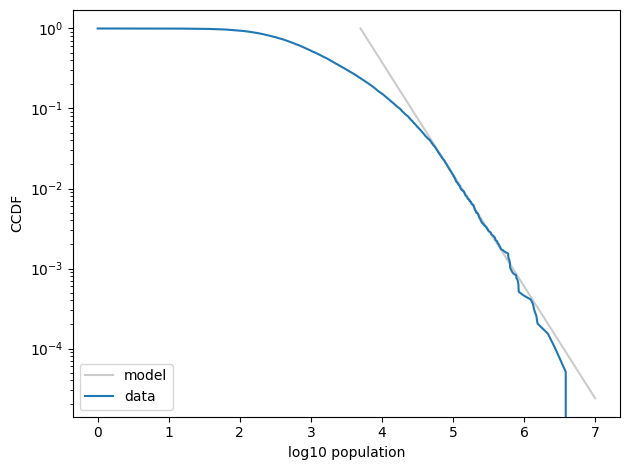

<IPython.core.display.Javascript object>

In [27]:
xs, ys = render_pareto_cdf(xmin=5000, alpha=1.4, low=0, high=10000000.0)
plt.plot(np.log10(xs), 1 - ys, label="model", color="0.8")

(1 - cdf_log).plot()

decorate(xlabel="log10 population", ylabel="CCDF", yscale="log", loc="lower left")

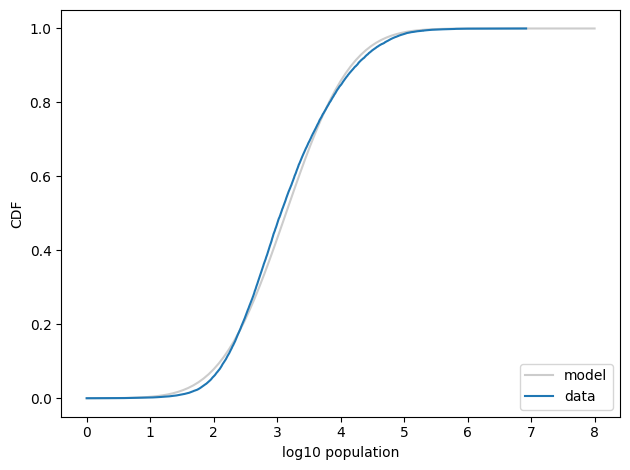

<IPython.core.display.Javascript object>

In [28]:
mu, sigma = log_pops.mean(), log_pops.std()
xs, ps = render_normal_cdf(mu, sigma, low=0, high=8)
plt.plot(xs, ps, label="model", color="0.8")
cdf_log.plot()
decorate(xlabel="log10 population", ylabel="CDF", loc="lower right")

## Generating random numbers

Analytic CDFs can be used to generate random numbers with a given distribution function, $p = CDF(x)$.
If there is an efficient way to compute the inverse CDF, we can generate random values with the appropriate distribution by choosing $p$ from a uniform distribution between 0 and 1, then choosing $x = ICDF(p)$.

For example, the CDF of the exponential distribution is $$p = 1 - e^{-\lambda x}$$ Solving for $x$ yields: $$x = -\log (1 - p) / \lambda$$ So in Python we can write

In [29]:
import random


def expovariate(lam):
    p = random.random()
    x = -np.log(1 - p) / lam
    return x

<IPython.core.display.Javascript object>

`expovariate` takes `lam` and returns a random value chosen from the exponential distribution with parameter `lam`.

Two notes about this implementation: I called the parameter `lam` because `lambda` is a Python keyword.
Also, since $\log 0$ is undefined, we have to be a little careful.
The implementation of `random.random` can return 0 but not 1, so $1 - p$ can be 1 but not 0, so `log(1-p)` is always defined.

In [30]:
t = [expovariate(lam=2) for _ in range(1000)]

<IPython.core.display.Javascript object>

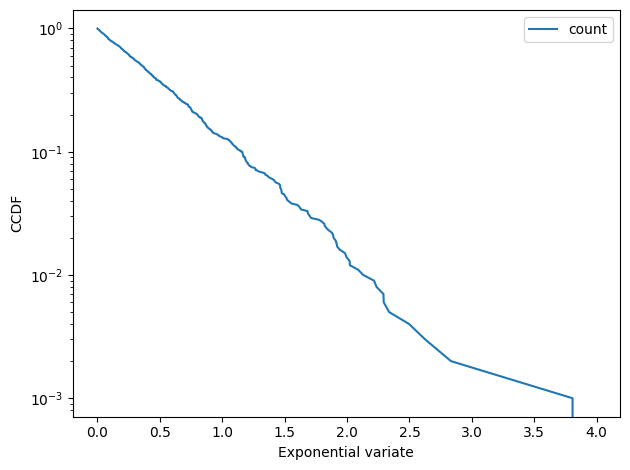

<IPython.core.display.Javascript object>

In [31]:
cdf = Cdf.from_seq(t)
(1 - cdf).plot()
decorate(xlabel="Exponential variate", ylabel="CCDF", yscale="log")

## Why model?

At the beginning of this chapter, I said that many real world phenomena can be modeled with analytic distributions.
"So," you might ask, "what?"

Like all models, analytic distributions are abstractions, which means they leave out details that are considered irrelevant.
For example, an observed distribution might have measurement errors or quirks that are specific to the sample; analytic models smooth out these idiosyncrasies.

Analytic models are also a form of data compression.
When a model fits a dataset well, a small set of parameters can summarize a large amount of data.

It is sometimes surprising when data from a natural phenomenon fit an analytic distribution, but these observations can provide insight into physical systems.
Sometimes we can explain why an observed distribution has a particular form.
For example, Pareto distributions are often the result of generative processes with positive feedback (so-called preferential attachment processes: see <http://wikipedia.org/wiki/Preferential_attachment>.).

Also, analytic distributions lend themselves to mathematical analysis, as we will see in Chapter [\[analysis\]](#analysis){reference-type="ref" reference="analysis"}.

But it is important to remember that all models are imperfect.
Data from the real world never fit an analytic distribution perfectly.
People sometimes talk as if data are generated by models; for example, they might say that the distribution of human heights is normal, or the distribution of income is lognormal.
Taken literally, these claims cannot be true; there are always differences between the real world and mathematical models.

Models are useful if they capture the relevant aspects of the real world and leave out unneeded details.
But what is "relevant" or "unneeded" depends on what you are planning to use the model for.

A straight line is consistent with an exponential distribution.

## Exercises

### Exercise

Write a function that generates a Pareto variate.
Generate a sample and plot its complementary CDF on a log-log scale.
Does it look like a straight line?

In [32]:
def sample_pareto(alpha, x_m, size):
    u = np.random.random(size)
    return x_m * pow(1 - u, -1 / alpha)

<IPython.core.display.Javascript object>

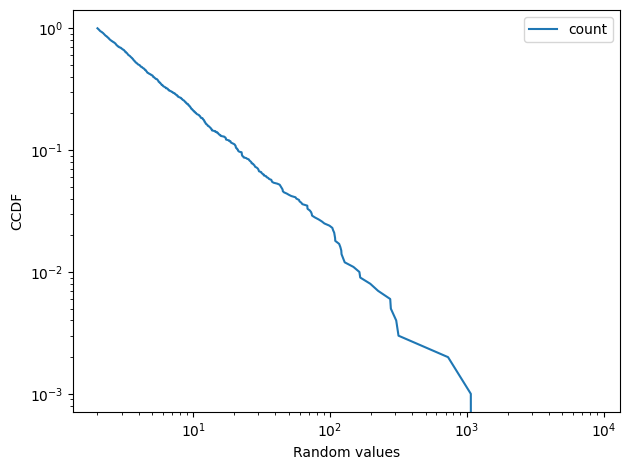

<IPython.core.display.Javascript object>

In [33]:
sample = sample_pareto(1, 2, 1000)
cdf = Cdf.from_seq(sample)
(1 - cdf).plot()
decorate(xlabel="Random values", ylabel="CCDF", xscale="log", yscale="log")

### Exercise

In the BRFSS (see Section 5.4), the distribution of heights is roughly normal with parameters µ = 178 cm and σ = 7.7 cm for men, and µ = 163 cm and σ = 7.3 cm for women.

In order to join Blue Man Group, you have to be male between 5’10” and 6’1” (see http://bluemancasting.com).
What percentage of the U.S. male population is in this range? Hint: use `scipy.stats.norm.cdf`.

`scipy.stats` contains objects that represent analytic distributions

In [34]:
import scipy.stats

<IPython.core.display.Javascript object>

For example <tt>scipy.stats.norm</tt> represents a normal distribution.

In [35]:
mu = 178
sigma = 7.7
dist = scipy.stats.norm(loc=mu, scale=sigma)

<IPython.core.display.Javascript object>

A "frozen random variable" can compute its mean and standard deviation.

In [36]:
dist.mean(), dist.std()

(178.0, 7.7)

<IPython.core.display.Javascript object>

It can also evaluate its CDF.
How many people are below the mean by more than one standard deviation?  About 16%

In [37]:
dist.cdf(mu - sigma)

0.1586552539314574

<IPython.core.display.Javascript object>

How many people are between 5'10" and 6'1"?

In [38]:
low = dist.cdf(177.8)
high = dist.cdf(185.4)
low, high, high - low

(0.48963902786483265, 0.8317337108107857, 0.3420946829459531)

<IPython.core.display.Javascript object>

### Exercise

To get a feel for the Pareto distribution, let's see how different the world would be if the distribution of human height were Pareto.
With the parameters xm = 1 m and α = 1.7, we get a distribution with a reasonable minimum, 1 m, and median, 1.5 m.

Plot this distribution.
What is the mean human height in Pareto world? What fraction of the population is shorter than the mean? If there are 7 billion people in Pareto world, how many do we expect to be taller than 1 km? How tall do we expect the tallest person to be?

`scipy.stats.pareto` represents a Pareto distribution.
In Pareto world, the distribution of human heights has parameters alpha=1.7 and xmin=1 meter.
So the shortest person is 100 cm and the median is 150.

In [39]:
alpha = 1.7
xmin = 1
dist = scipy.stats.pareto(b=alpha, scale=xmin)
dist.median()

1.5034066538560549

<IPython.core.display.Javascript object>

What is the mean height in Pareto world?

In [40]:
dist.mean()

2.428571428571429

<IPython.core.display.Javascript object>

What fraction of people are shorter than the mean?

In [41]:
dist.cdf(dist.mean())

0.778739697565288

<IPython.core.display.Javascript object>

Out of 7 billion people, how many do we expect to be taller than 1 km?  You could use <tt>dist.cdf</tt> or <tt>dist.sf</tt>.

In [42]:
(1 - dist.cdf(1000)) * 7000000000.0, dist.sf(1000) * 7000000000.0

(55602.976430479954, 55602.97643069972)

<IPython.core.display.Javascript object>

How tall do we expect the tallest person to be?

In [43]:
dist.sf(600000) * 7000000000.0

1.0525455861201714

<IPython.core.display.Javascript object>

In [44]:
dist.ppf(1 - 1 / 7000000000.0)

618349.6106759505

<IPython.core.display.Javascript object>

### Exercise

The Weibull distribution is a generalization of the exponential distribution that comes up in failure analysis (see http://wikipedia.org/wiki/Weibull_distribution).
Its CDF is

$\mathrm{CDF}(x) = 1 − \exp[−(x / λ)^k]$ 

Can you find a transformation that makes a Weibull distribution look like a straight line? What do the slope and intercept of the line indicate?

Use `random.weibullvariate` to generate a sample from a Weibull distribution and use it to test your transformation.

Generate a sample from a Weibull distribution and plot it using a transform that makes a Weibull distribution look like a straight line.

Here's an example that shows how it's used.

In [45]:
# TODO: implement the Weibull transform

<IPython.core.display.Javascript object>

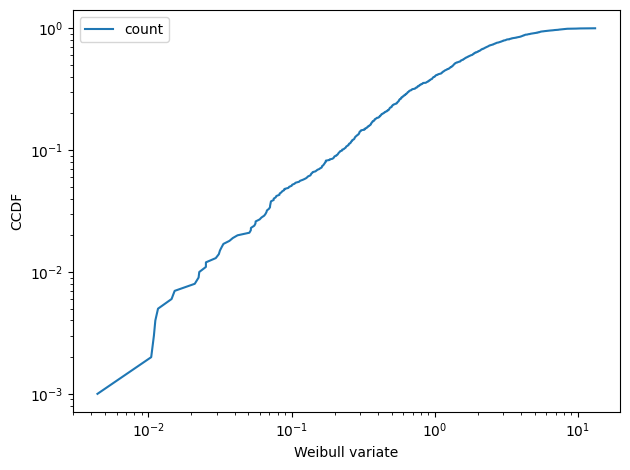

<IPython.core.display.Javascript object>

In [46]:
sample = [random.weibullvariate(2, 1) for _ in range(1000)]
cdf = Cdf.from_seq(sample)
cdf.plot()
decorate(xlabel="Weibull variate", ylabel="CCDF", xscale="log", yscale="log")

### Exercise

For small values of `n`, we don’t expect an empirical distribution to fit an analytic distribution exactly.
One way to evaluate the quality of fit is to generate a sample from an analytic distribution and see how well it matches the data.

For example, in Section 5.1 we plotted the distribution of time between births and saw that it is approximately exponential.
But the distribution is based on only 44 data points.
To see whether the data might have come from an exponential distribution, generate 44 values from an exponential distribution with the same mean as the data, about 33 minutes between births.

Plot the distribution of the random values and compare it to the actual distribution.
You can use random.expovariate to generate the values.

In [47]:
df = read_baby_boom()
diffs = df.minutes.diff()
cdf_diffs = Cdf.from_seq(diffs, name="actual")

<IPython.core.display.Javascript object>

In [48]:
n = len(diffs)
lam = 44.0 / 24 / 60
sample = [random.expovariate(lam) for _ in range(n)]
1 / lam, np.mean(sample)

(32.72727272727273, 40.85751680004956)

<IPython.core.display.Javascript object>

In [49]:
model = Cdf.from_seq(sample, name="model")

<IPython.core.display.Javascript object>

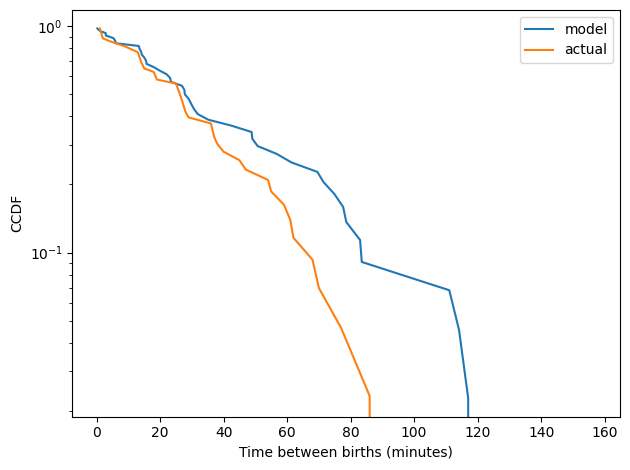

<IPython.core.display.Javascript object>

In [50]:
(1 - model).plot()
(1 - cdf_diffs).plot()
decorate(xlabel="Time between births (minutes)", ylabel="CCDF", yscale="log")

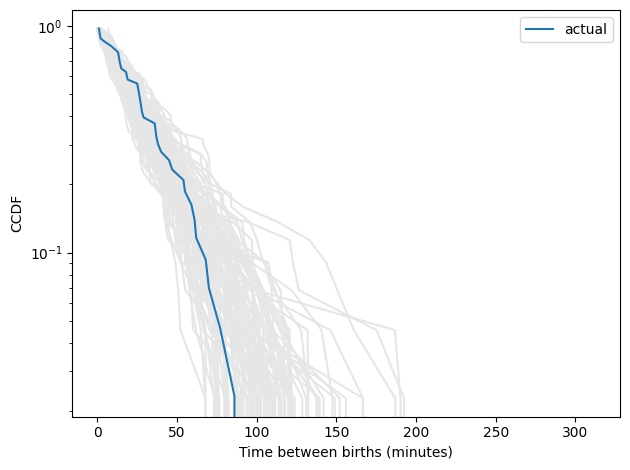

<IPython.core.display.Javascript object>

In [51]:
for i in range(100):
    sample = [random.expovariate(lam) for _ in range(n)]
    cdf = Cdf.from_seq(sample, name="")
    (1 - cdf).plot(color="0.9")
(1 - cdf_diffs).plot()
decorate(xlabel="Time between births (minutes)", ylabel="CCDF", yscale="log")

**Bonus Example:** The distributions of wealth and income are sometimes modeled using lognormal and Pareto distributions.
To see which is better, let’s look at some data.

The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables.
Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm.
I downloaded `hinc06.xls`, which is an Excel spreadsheet with information about household income, and converted it to `hinc06.csv`, a CSV file you will find in the repository for this book.
You will also find `hinc.py`, which reads this file.

Extract the distribution of incomes from this dataset.
Are any of the analytic distributions in this chapter a good model of the data?

In [52]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/hinc.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/hinc06.csv")

<IPython.core.display.Javascript object>

In [53]:
import hinc

df = hinc.read_data()
df

,income,freq,cumsum,ps
0,4999.0,4204,4204,0.034330
1,9999.0,4729,8933,0.072947
2,14999.0,6982,15915,0.129963
3,19999.0,7157,23072,0.188407
4,24999.0,7131,30203,0.246640
5,29999.0,6740,36943,0.301679
6,34999.0,6354,43297,0.353566
7,39999.0,5832,49129,0.401191
8,44999.0,5547,54676,0.446488
9,49999.0,5254,59930,0.489392


<IPython.core.display.Javascript object>

Here's what the CDF looks like on a linear scale.

In [54]:
xs, ps = df.income.values, df.ps.values

cdf = Cdf(ps, xs, name="data")
cdf_log = Cdf(ps, np.log10(xs), name="log data")

<IPython.core.display.Javascript object>

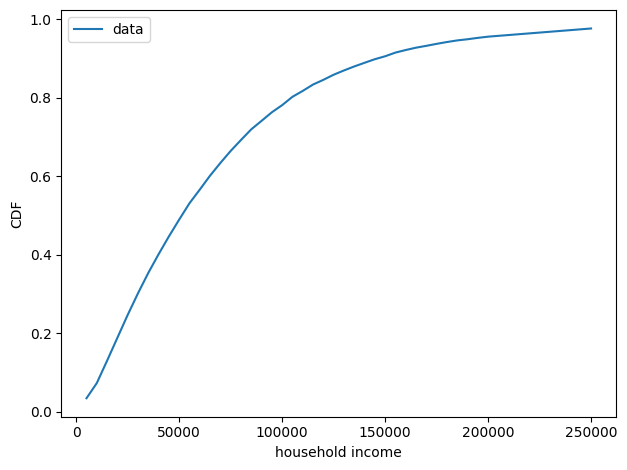

<IPython.core.display.Javascript object>

In [55]:
cdf.plot()
decorate(xlabel="household income", ylabel="CDF")

To check whether a Pareto model describes the data well, I plot the CCDF on a log-log scale.

I found parameters for the Pareto model that match the tail of the distribution.

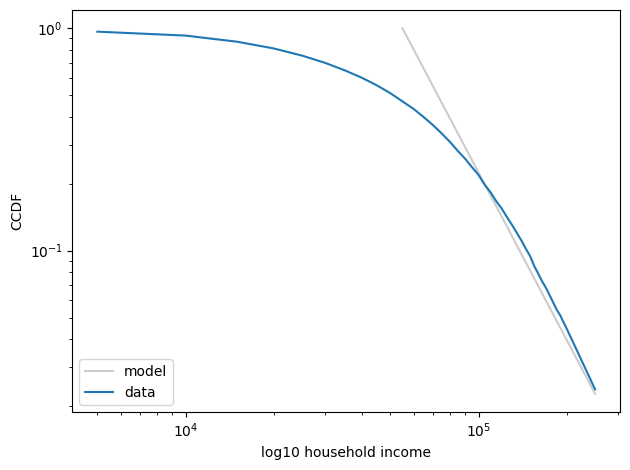

<IPython.core.display.Javascript object>

In [56]:
xs, ys = render_pareto_cdf(xmin=55000, alpha=2.5, low=0, high=250000)
plt.plot(xs, 1 - ys, label="model", color="0.8")
(1 - cdf).plot()
decorate(
    xlabel="log10 household income",
    ylabel="CCDF",
    xscale="log",
    yscale="log",
    loc="lower left",
)

For the lognormal model I estimate mu and sigma using percentile-based statistics (median and IQR).

In [57]:
median = cdf_log.inverse(0.5)
iqr = cdf_log.inverse([0.25, 0.75])
std = np.diff(iqr) / 1.349
std = 0.35
print(median, std)

4.740354793159152 0.35


<IPython.core.display.Javascript object>

Here's what the distribution, and fitted model, look like on a log-x scale.

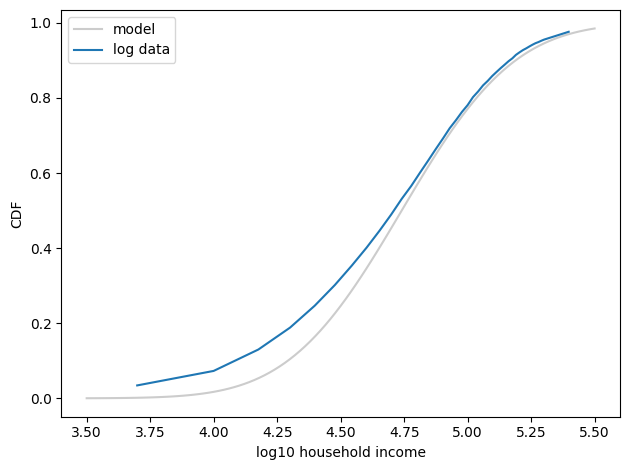

<IPython.core.display.Javascript object>

In [58]:
xs, ps = render_normal_cdf(median, std, low=3.5, high=5.5)
plt.plot(xs, ps, label="model", color="0.8")
cdf_log.plot()
decorate(xlabel="log10 household income", ylabel="CDF")

My conclusions based on these figures are:

1) The Pareto model might be a reasonable choice for the top    10-20% of incomes.

2) The lognormal model captures the shape of the distribution better,    with some deviation in the left tail.
With different    choices for sigma, you could match the upper or lower tail, but not    both at the same time.
In summary I would say that neither model captures the whole distribution, so you might have to 

1) look for another analytic model, 

2) choose one that captures the part of the distribution that is most relevent, or 

3) avoid using an analytic model altogether.